In [ ]:
!git clone https://github.com/hojunkim13/PINNs/blob/main/Heat/main.py

Cloning into 'main.py'...
fatal: repository 'https://github.com/hojunkim13/PINNs/blob/main/Heat/main.py/' not found


In [ ]:
import torch
import torch.nn as nn
import numpy as np

torch.backends.cuda.matmul.allow_tf32 = (
    False  # This is for Nvidia Ampere GPU Architechture
)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(1234)
np.random.seed(1234)


class layer(nn.Module):
    def __init__(self, n_in, n_out, activation):
        super().__init__()
        self.layer = nn.Linear(n_in, n_out)
        self.activation = activation

    def forward(self, x):
        x = self.layer(x)
        if self.activation:
            x = self.activation(x)
        return x


class DNN(nn.Module):
    def __init__(self, dim_in, dim_out, n_layer, n_node, ub, lb, activation=nn.Tanh()):
        super().__init__()
        self.net = nn.ModuleList()
        self.net.append(layer(dim_in, n_node, activation))
        for _ in range(n_layer):
            self.net.append(layer(n_node, n_node, activation))
        self.net.append(layer(n_node, dim_out, activation=None))
        self.ub = torch.tensor(ub, dtype=torch.float).to(device)
        self.lb = torch.tensor(lb, dtype=torch.float).to(device)
        self.net.apply(weights_init)  # xavier initialization

    def forward(self, x):
        x = (x - self.lb) / (self.ub - self.lb)  # Min-max scaling
        out = x
        for layer in self.net:
            out = layer(out)
        return out


def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        torch.nn.init.zeros_(m.bias.data)

500, Loss : 5.99092e-01, ic : 2.259e-01, bc : 3.269e-01, f : 4.628e-02
1000, Loss : 2.61592e-01, ic : 7.851e-02, bc : 1.500e-01, f : 3.304e-02
1500, Loss : 1.69958e-01, ic : 4.799e-02, bc : 1.038e-01, f : 1.818e-02
2000, Loss : 1.76867e-01, ic : 2.630e-02, bc : 1.137e-01, f : 3.682e-02
2500, Loss : 1.74695e-01, ic : 2.814e-02, bc : 7.361e-02, f : 7.295e-02
3000, Loss : 1.09316e-01, ic : 3.172e-02, bc : 4.884e-02, f : 2.875e-02
3500, Loss : 1.10551e-01, ic : 3.433e-02, bc : 4.088e-02, f : 3.534e-02
4000, Loss : 6.60000e-02, ic : 1.996e-02, bc : 4.048e-02, f : 5.557e-03
4500, Loss : 1.55381e-01, ic : 3.217e-02, bc : 9.122e-02, f : 3.199e-02
5000, Loss : 9.87698e-02, ic : 2.284e-02, bc : 6.289e-02, f : 1.304e-02
5500, Loss : 7.67371e-03, ic : 1.486e-03, bc : 2.561e-03, f : 3.626e-03
6000, Loss : 1.96405e-03, ic : 3.819e-04, bc : 3.991e-04, f : 1.183e-03
6500, Loss : 9.42017e-04, ic : 1.353e-04, bc : 1.426e-04, f : 6.641e-04
7000, Loss : 5.45165e-04, ic : 4.854e-05, bc : 8.082e-05, f : 4.1

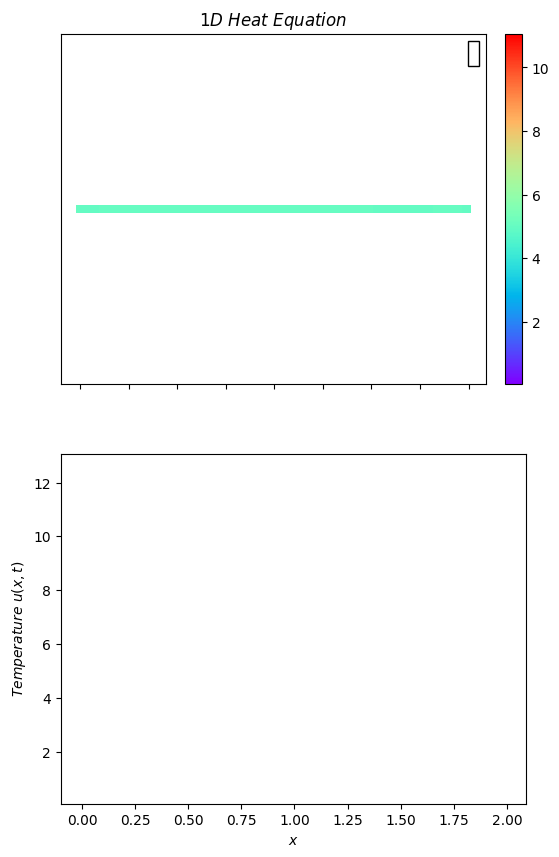

In [ ]:
import sys

sys.path.append(".")
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from torch.autograd import grad
from matplotlib.animation import FuncAnimation

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

N_0 = 200
N_bc = 400
N_f = 10000

x_min = 0.0
x_max = 2.0
t_min = 0.0
t_max = 1.0

ub = np.array([x_max, t_max])
lb = np.array([x_min, t_min])

# initial condition, u(x, 0) = f(x)

xt_0 = np.random.uniform([x_min, 0], [x_max, 0], size=(N_0, 2))
u_0 = np.ones_like(xt_0[:, 0:1]) * 5


# Boundary Condition
# u(0, t) = 10 & u(L, t) = 0 for t > 0

xt_bc_0 = np.random.uniform([x_min, t_min], [x_min, t_max], size=(N_bc // 2, 2))
u_bc_0 = np.ones((len(xt_bc_0), 1)) * 10

xt_bc_1 = np.random.uniform([x_max, t_min], [x_max, t_max], size=(N_bc // 2, 2))
u_bc_1 = np.zeros((len(xt_bc_1), 1))

xt_bc = np.vstack([xt_bc_0, xt_bc_1])
u_bc = np.vstack([u_bc_0, u_bc_1])

xt_f = np.random.uniform(lb, ub, (N_f, 2))
xt_f = np.vstack([xt_0, xt_bc, xt_f])

# Convert to Tensor
xt_0 = torch.tensor(xt_0, dtype=torch.float32).to(device)
u_0 = torch.tensor(u_0, dtype=torch.float32).to(device)

xt_bc = torch.tensor(xt_bc, dtype=torch.float32).to(device)
u_bc = torch.tensor(u_bc, dtype=torch.float32).to(device)

xt_f = torch.tensor(xt_f, dtype=torch.float32).to(device)


class PINN:
    c = 0.8

    def __init__(self) -> None:
        self.net = DNN(dim_in=2, dim_out=1, n_layer=7, n_node=40, ub=ub, lb=lb).to(
            device
        )
        self.lbfgs = torch.optim.LBFGS(
            self.net.parameters(),
            lr=1.0,
            history_size=50,
            max_eval=10000,
            max_iter=10000,
        )
        self.adam = torch.optim.Adam(self.net.parameters())
        self.iter = 0

    def f(self, xt):
        xt = xt.clone()
        xt.requires_grad = True

        u = self.net(xt)
        u_xt = grad(u.sum(), xt, create_graph=True)[0]
        u_x = u_xt[:, 0:1]
        u_t = u_xt[:, 1:2]
        u_xx = grad(u_x.sum(), xt, create_graph=True)[0][:, 0:1]
        f = u_t - self.c ** 2 * u_xx
        return f

    def closure(self):
        self.lbfgs.zero_grad()
        self.adam.zero_grad()

        u0_pred = self.net(xt_0)
        mse_0 = torch.mean(torch.square(u0_pred - u_0))
        u_bc_pred = self.net(xt_bc)
        mse_bc = torch.mean(torch.square(u_bc_pred - u_bc))

        f_pred = self.f(xt_f)
        mse_f = torch.mean(torch.square(f_pred))
        loss = mse_0 + mse_bc + mse_f
        loss.backward()
        self.iter += 1
        print(
            f"\r{self.iter}, Loss : {loss.item():.5e}, ic : {mse_0:.3e}, bc : {mse_bc:.3e}, f : {mse_f:.3e}",
            end="",
        )

        if self.iter % 500 == 0:
            print("")
        return loss


pinn = PINN()
for i in range(5000):
    pinn.closure()
    pinn.adam.step()
pinn.lbfgs.step(pinn.closure)

####################### Plot ########################
x = np.arange(x_min, x_max, 0.01)
t = np.arange(t_min, t_max, 0.01)

X, T = np.meshgrid(x, t)

X = X.reshape(-1, 1)
T = T.reshape(-1, 1)
xt_f = np.hstack([X, T])
xt_f = torch.tensor(xt_f, dtype=torch.float32).to(device)

u_pred = pinn.net(xt_f)
u_pred = u_pred.detach().cpu().numpy()

u_pred = u_pred.reshape(len(x), len(t), order="F")

fig, axes = plt.subplots(2, 1, figsize=(6, 10), sharex=True)
bar_x = np.linspace(x_min, x_max, u_pred.shape[0])
bar_y = np.zeros_like(bar_x)
axes[0].set_title("$1D\ Heat\ Equation$")
axes[0].set_yticks([])

im0 = axes[0].scatter(
    x,
    np.zeros_like(x),
    c=u_pred[:, 0],
    marker="s",
    cmap="rainbow",
    lw=0,
    vmin=u_pred.min() * 1.1,
    vmax=u_pred.max() * 1.1,
)
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04, extend="neither")
textbox = offsetbox.AnchoredText("", loc=1)
axes[0].add_artist(textbox)

(im1,) = axes[1].plot([], [], color="k")
axes[1].set_ylim(u_pred.min() * 1.3, u_pred.max() * 1.3)
axes[1].set_xlabel("$x$")
axes[1].set_ylabel("$Temperature\ u(x,t)$")


def update(frame):
    temp = u_pred[:, frame]
    im0.set_array(temp)
    im1.set_data(bar_x, temp)
    textbox = offsetbox.AnchoredText(f"{t[frame]:.2f} sec", loc=1)
    axes[0].add_artist(textbox)


ani = FuncAnimation(fig, update, frames=len(t), interval=50)
plt.show()
ani.save("solution.gif", dpi=100)

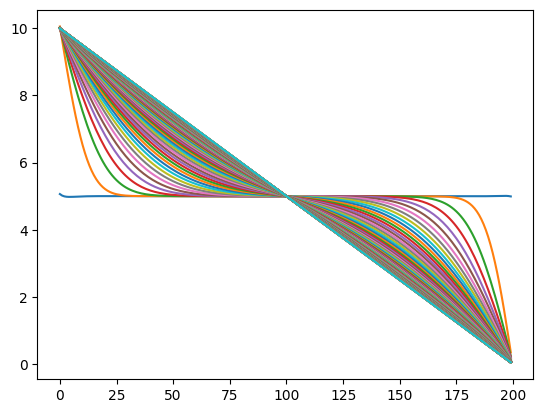

In [ ]:
plt.plot(u_pred)
plt.show()

In [ ]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()
writer.add_graph(pinn.net, xt_f)

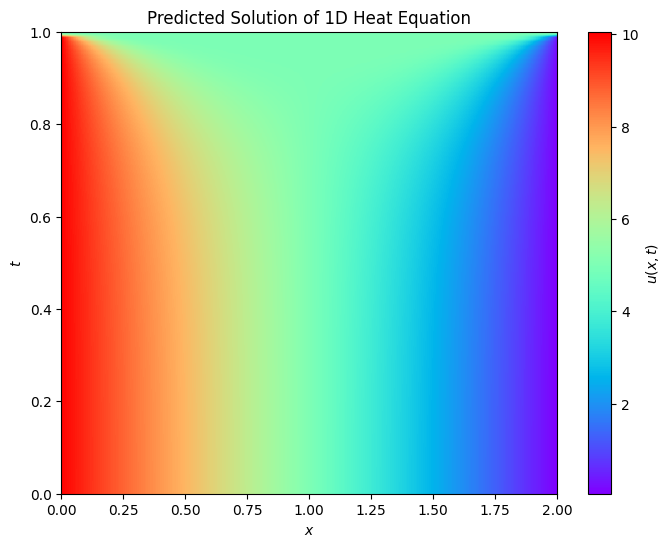

In [ ]:
# Create a subplot for the 1D Heat Equation
fig, axes = plt.subplots(figsize=(8, 6))

# Plot the predicted solution using a 2D surface plot
im = axes.imshow(u_pred.T, extent=[x_min, x_max, t_min, t_max], aspect='auto', cmap='rainbow')
axes.set_title('Predicted Solution of 1D Heat Equation')
axes.set_xlabel('$x$')
axes.set_ylabel('$t$')
fig.colorbar(im, label='$u(x, t)$')

plt.show()